In [39]:
import pandas as pd
import sqlalchemy

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
import scipy.stats as stats

In [323]:
from IPython.display import display, Markdown, SVG
import io

def check(what: pd.Series, nbins=None):
    if type(what) is pd.Series:
        txt = f'#### Checking {what.name}'
        display(Markdown(txt))
        
        # numeric dtypes can be plotted
        if pd.api.types.is_numeric_dtype(what) and not pd.api.types.is_bool_dtype(what):
            plt.ioff()
            desc = what.describe()
            for key in desc.keys():
                try:
                    desc[key] = round(desc[key], 2)
                except Exception:
                    pass
            try:
                mode = f"{what.mode()[0] :.02f}"
            except Exception:
                mode = what.mode()[0]
            
            data = {
                'col. name': what.name,
                'len':       len(what),
                'dtype':     what.dtype,
                '#NA':       what.isna().sum(),
                '%Non-NA':   f"{what.count() / len(what) * 100:.02f}",
                '#Unique':   what.nunique(),
                '%Unique':   f"{what.nunique() / what.count() * 100:.02f}",
                'Mode':      mode,
                '%Mode':     f"{(what == what.mode()[0]).sum() / what.count() * 100:.02f}",
                **desc
            }
            
            table_data = pd.DataFrame(data, index=['Value']).T
            
            fig, ax  = plt.subplots(figsize=(15,5), ncols=2, gridspec_kw={'width_ratios': [3, 1]})
            ax[1].table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, loc='center')
            ax[1].set_axis_off()
            
            # hist
            ax_hist = what.plot.hist(ax=ax[0], color='#1B998B', edgecolor='#052E29')
            # kde
            ax_kde = what.plot.kde(ax=ax[0], secondary_y=True, color='#F0544F')
            
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            plt.subplots_adjust(hspace=0)
            fig.suptitle(f'Checking "{what.name}"')
            ax[0].set_ylabel('Frequency')
            ax_kde.set_ylabel('Density')
            ax[0].grid(True, color="#000000", alpha=0.15, axis='y')
            ax_kde.grid(True, color="#F0544F", alpha=0.15, axis='y')
            ax[0].tick_params(axis=u'both', which=u'both',length=0)
            ax_kde.tick_params(axis=u'both', which=u'both',length=0)
            ax[0].spines[['top', 'left', 'right']].set_visible(False)
            fig.tight_layout()
            plt.show()
            plt.ion()
        
        # non-numeric ones can still be checked with the table
        else:
            txt = f'name | {what.name}\n-|-\n'
            txt += f'len | {len(what)} \n'
            txt += f'dtype | {what.dtype} \n'
            txt += f'#NA | {what.isna().sum()} \n'
            txt += f'%Non-NA | {what.count() / len(what) * 100:.02f} \n'
            txt += f'#Unique | {what.nunique()} \n'
            txt += f'%Unique | {what.nunique() / what.count() * 100:.02f} \n'
            txt += f'Mode | {what.mode()[0]} \n'
            txt += f'%Mode | {(what == what.mode()[0]).sum() / what.count() * 100:.02f} \n'
            d = what.describe()
            for _ in d.index:
                txt += f'{_} | {d.loc[_]} \n'
            display(Markdown(txt))


In [51]:
def categoric_barplot(df, col_name, ordered=False, ygrid=False):
    fig, ax  = plt.subplots(figsize=(10,5))
    ax.set_title(f'Bar plot of {col_name}')
    data = df.groupby(col_name).count().max(axis=1).sort_values() if ordered else df.groupby(col_name).count().max(axis=1)
    data.plot.bar(ax=ax, color='#1B998B', edgecolor='#052E29')
    ax.spines[['top', 'left', 'right']].set_visible(False)
    ax.set_ylabel('Count')
    if ygrid:
        ax.grid(True, color='#3B322C', alpha=0.2, axis='y')
    fig.tight_layout()

In [53]:
def histogram(col, nbins=None, with_kde=True, ygrid=False):
    # set it up
    fig, ax  = plt.subplots(figsize=(10,5))
    # some formatting
    # check col type
    if isinstance(col, str):
        # set title
        ax.set_title(f'Histogram of {col}')
        # set bins
        if nbins:
            ax_hist = df[col].plot.hist(ax=ax, bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = df[col].plot.hist(ax=ax, color='#1B998B', edgecolor='#052E29')
        # kde
        if with_kde:
            ax_kde = df[col].plot.kde(ax=ax, secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')
    # if something like a filtered column or a series is given
    else:
        # set title
        ax.set_title(f'Histogram of {col.name}')
        # set bins
        if nbins:
            ax_hist = col.plot.hist(ax=ax, bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = col.plot.hist(ax=ax, color='#1B998B', edgecolor='#052E29')
        # kde
        if with_kde:
            ax_kde = col.plot.kde(ax=ax, secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')
    # fix the y label
    ax_hist.set_ylabel('Frequency')
    # grids
    if ygrid:
        ax_hist.grid(True, color='#3B322C', alpha=0.2, axis='y')
        ax_kde.grid(True, color='#3B322C', alpha=0.2, axis='y')

    ax.spines[['top', 'left', 'right']].set_visible(False)
    fig.tight_layout()

In [ ]:
def histogram_boxplot(col, nbins=None, with_kde=True, ygrid=False, fs=(10,6.5), ):
    # pretty much the same function as `histogram`, with added complication for showing a box plot under the x axis
    # it is kinda hack-ish, but looks pretty cool
    # set it up
    # fig, ax  = plt.subplots(figsize=fs, nrows=2, sharex=True)
    fig, ax  = plt.subplots(figsize=fs, nrows=2, sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': -0.15})
    # some formatting
    # check col type
    if isinstance(col, str):
        fig.suptitle(f'Histogram and Box Plot of {col}')
        # set bins
        if nbins:
            ax_hist = df[col].plot.hist(ax=ax[0], bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = df[col].plot.hist(ax=ax[0], color='#1B998B', edgecolor='#052E29')
        ax_bp = df[col].plot.box(ax=ax[1], color='#001614', vert=False)
        # kde
        if with_kde:
            ax_kde = df[col].plot.kde(ax=ax[0], secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')
    # if something like a filtered column or a series is given
    else:
        fig.suptitle(f'Histogram and Box Plot of {col.name}')
        # set bins
        if nbins:
            ax_hist = col.plot.hist(ax=ax[0], bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = col.plot.hist(ax=ax[0], color='#1B998B', edgecolor='#052E29')
        ax_bp = col.plot.box(ax=ax[1], color='#001614', vert=False)
        # kde
        if with_kde:
            ax_kde = col.plot.kde(ax=ax[0], secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')

    # fix the y label
    ax_hist.set_ylabel('Frequency')
    ax_hist.xaxis.set_tick_params(labelbottom=True)
    # ax_kde.set_ylabel('Density')
    # ax_bp.set_yticklabels('')
    ax_bp.set_yticklabels([])
    ax_bp.set_yticks([])
    ax_bp.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax_bp.set_axis_off()

    plt.subplots_adjust(hspace=0)

    # grids
    if ygrid:
        ax_hist.grid(True, color='#3B322C', alpha=0.2, axis='y')
        ax_kde.grid(True, color="#913F08", alpha=0.2, axis='y')
    ax[0].spines[['top', 'left', 'right']].set_visible(False)
    # fig.tight_layout()

In [55]:
def compare_histograms(data: list, ygrid=False, alpha=None, labels=None, nbins=None):
    fig, ax  = plt.subplots(figsize=(10,5))
    alpha = 1/(len(data)) if alpha is None else alpha
    if isinstance(data, list):
        ax.set_title(f'Comparing Histograms')
        colors = sns.color_palette('dark')
        i = 0
        for d in data:
            if labels:
                if nbins:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=labels[i], bins=nbins)
                else:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=labels[i])
            else:
                if nbins:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=f'Series {i+1}', bins=nbins)
                else:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=f'Series {i+1}')
            i += 1
        ax.legend()
        ax.spines[['top', 'left', 'right']].set_visible(False)
        if ygrid:
            ax.grid(True, color='#3B322C', alpha=0.2, axis='y')
        fig.tight_layout()
    else:
        raise TypeError('You should provide a list of data series')

In [56]:
def pie(what, pct=True, w=0.3):
    fig, ax  = plt.subplots(figsize=(5,5))
    colors = sns.color_palette('pastel')
    if isinstance(what, pd.Series):
        if pct:
            what.value_counts().plot.pie(ax=ax, colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            what.value_counts().plot.pie(ax=ax, colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
        ax.set_title(f'Pie Chart of {what.name}')
        ax.set_ylabel('')
        fig.tight_layout()
    
    elif isinstance(what, str):
        if pct:
            df[what].value_counts().plot.pie(ax=ax, colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            df[what].value_counts().plot.pie(ax=ax, colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
        ax.set_title(f'Pie Chart of {what}')
        ax.set_ylabel('')
        fig.tight_layout()
    
    else:
        raise TypeError('you must provide either a data-series or a column name to be read from DataFrame `df`')

In [57]:
def pies(df, cols, pct=True, w=0.3, base_size=4, show_val=True):
    fig, ax  = plt.subplots(figsize=(base_size*len(cols),5), ncols=len(cols))
    colors = sns.color_palette('pastel')
    i = 0
    for col in cols:
        if pct:
            ax_p = df[col].value_counts().plot.pie(ax=ax[i], colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            ax_p = df[col].value_counts().plot.pie(ax=ax[i], colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})

        if show_val:
            ax_p.set_xlabel(f'{df[col].count()} of {len(df[col])} values')
        ax_p.set_ylabel('')
        ax_p.set_title(f'Pie Chart of {col}')
        i += 1
    plt.subplots_adjust(wspace=0)
    fig.tight_layout()

In [58]:

def ratio_per_group(df, group, target, show_ratios=False, ax=None, fs=(10, 5), norm='columns', normalize=True, sort=False):
    ct = pd.crosstab(df[target], df[group], normalize=norm).T if not sort else pd.crosstab(df[target], df[group], normalize=norm).T.sort_values(1)
    if normalize:
        if ax is not None:
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        else:
            fig, ax  = plt.subplots(figsize=fs)
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        if show_ratios:
            xlabels = [f'{c}\n{ct.loc[c, 0]*100:.01f} : {ct.loc[c, 1]*100:.01f}' for c in ct.index]
            ax.set_xticklabels(xlabels)
    else:
        if sort:
            ct = pd.crosstab(df[target], df[group]).T.reindex_like(pd.crosstab(df[target], df[group], normalize=norm).T.sort_values(1))
        else:
            ct = pd.crosstab(df[target], df[group]).T
        if ax is not None:
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        else:
            fig, ax  = plt.subplots(figsize=fs)
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        if show_ratios:
            xlabels = [f'{c}\n{ct.loc[c, 0]} : {ct.loc[c, 1]}' for c in ct.index]
            ax.set_xticklabels(xlabels)
    ax.spines[['top', 'left', 'right']].set_visible(False)
    ax.set_xlabel('')
    if ax is None:
        fig.suptitle(f'Comparing {target} ratio over {group}')
        fig.tight_layout()

In [59]:
def frequency_ratio_per_group(df, group, target, show_ratios=False, ax=None, fs=(10, 10), sort=False):
    fig, ax  = plt.subplots(figsize=fs, nrows=2)
    ax[0].set_title('Frequency Ratios')
    ratio_per_group(df, group, target, show_ratios=show_ratios, normalize=False, ax=ax[0], sort=sort)
    ax[1].set_title('Normalized Ratios')
    ratio_per_group(df, group, target, show_ratios=show_ratios, normalize=True, ax=ax[1], sort=sort)
    for x in ax:
            x.spines[['top', 'left', 'right']].set_visible(False)
    fig.suptitle(f'{group}')
    fig.tight_layout()

In [60]:
def pies_ratios(df, cols, target, pct=True, w=0.3, base_size=4, show_val=True, show_ratios=False, fs=(10, 5)):
    fs = (base_size*len(cols),5) if not isinstance(cols, str) else fs
    fig, ax  = plt.subplots(figsize=fs, ncols=len(cols) if not isinstance(cols, str) else 1, nrows=2)
    colors = sns.color_palette('Set2')
    i = 0
    if isinstance(cols, str):
        if pct:
            ax_p = df[cols].value_counts().plot.pie(ax=ax[0], colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            ax_p = df[cols].value_counts().plot.pie(ax=ax[0], colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
        ratio_per_group(df, cols, target, ax=ax[1], show_ratios=show_ratios)
        ax_p.set_ylabel('')
        ax_p.set_title(f'{cols}')

    else:
        for col in cols:
            if pct:
                ax_p = df[col].value_counts().plot.pie(ax=ax[0, i], colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
            else:
                ax_p = df[col].value_counts().plot.pie(ax=ax[0, i], colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
            ratio_per_group(df, col, target, ax=ax[1, i], show_ratios=show_ratios)
            if show_val:
                ax_p.set_xlabel(f'{df[col].count()} of {len(df[col])} values')
            ax_p.set_ylabel('')
            ax_p.set_title(f'{col}')
            i += 1
    plt.subplots_adjust(wspace=0)
    fig.tight_layout()

In [61]:
def boxplot(what, show_median=True, fs=(10,5), rot=0, grid=False):
    fig, ax  = plt.subplots(figsize=fs)
    what.plot.box(ax=ax, color="#001614", vert=False)
    if show_median:
        ax.text(what.median(), 1, f'{what.median():.02f}', rotation=rot)
    # formatting
    ax.set_title(f'Box plot of {what.name}')
    ax.yaxis.set_ticklabels([])
    ax.spines[['top', 'left', 'right']].set_visible(False)
    if grid:
        ax.grid(color='#3B322C', alpha=0.2, axis='x')
    fig.tight_layout()

In [62]:
def boxplots(df, what, by, show_medians=True, fs=(10,5), rot=0, ygrid=True):
    fig, ax  = plt.subplots(figsize=fs)

    pd.plotting.boxplot(df, what, by, ax=ax, color="#001614")
    # fix formatting
    ax.grid(False, axis='x')
    fig.suptitle('')
    if not ygrid:
        ax.grid(False, axis='y')
    else:
        ax.grid(color='#3B322C', alpha=0.2, axis='y')


    if show_medians:
        medians = df.groupby(by).agg({what: 'median'})
        i = 1
        for g in medians.index:
            ax.text(i, medians.loc[g].iloc[0], f'{medians.loc[g].iloc[0]:.02f}', rotation=rot)
            i += 1

    # formatting
    ax.set_title(f'Box plots of {what} by {by}')
    ax.spines[['top', 'right']].set_visible(False)
    fig.tight_layout()

In [63]:
def scatter(df, x, y, c=None, fs=(10, 5), alpha=1):
    fig, ax  = plt.subplots(figsize=fs)
    if c is None:
        df.plot.scatter(x, y, ax=ax, alpha=alpha)
        ax.set_title(f'{y} by {x}')
    else:
        df.plot.scatter(x, y, c=c, ax=ax, cmap=plt.get_cmap('winter'), alpha=alpha)
        ax.set_title(f'{y} by {x} and {c}')

    # formatting
    ax.spines[['left', 'top', 'right']].set_visible(False)
    fig.tight_layout()

In [64]:
def corr_heatmap(df, fs=(15, 15), method='spearman', numeric_only=False, triangular=False):
    corr_matrix = df.corr(method=method, numeric_only=numeric_only)
    fig, ax  = plt.subplots(figsize=fs)
    sns.heatmap(corr_matrix, cmap='viridis', ax=ax, mask=np.tri(len(corr_matrix)).T if triangular else None)
    ax.set_title('Correlation Heatmap')

In [65]:
def violin(df: pd.DataFrame, x_name: str, split_on: str, inner='quart', fs=(5, 5)):
    fig, ax = plt.subplots(figsize=fs)
    sns.violinplot(df, x=x_name, hue=split_on, palette=sns.color_palette('pastel'), inner=inner, ax=ax, split=True)
    ax.set_title(f'Split-violin plots of {x_name} split by {split_on}')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    fig.tight_layout()

In [66]:
def violins(df: pd.DataFrame, x_name: str, y_name: str, split_on: str, inner='quart', fs=(10, 5)):
    fig, ax = plt.subplots(figsize=fs)
    sns.violinplot(df, x=x_name, y=y_name, hue=split_on, palette=sns.color_palette('pastel'), inner=inner, ax=ax, split=True)
    ax.set_title(f'Split-violin plots of {x_name} by {y_name}, split by {split_on}')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    fig.tight_layout()

<div dir=rtl>

# تحلیل

</div>

<div dir=rtl>

## آمار توصیفی

</div>

<div dir=rtl>

### توزیع قد بازیکنان Michael Jordan Trophy با ۵۰ بازیکن برتر هر فصل

از فصل ۲۰۱۹-۲۰۲۰ تا پایان فصل ۲۰۲۳-۲۰۲۴
(۵ فصل)
:

</div>

In [7]:
conn = sqlalchemy.create_engine("sqlite:///../db/main.db")

In [217]:
df_players = pd.read_sql_table("players", conn)

# df_players.head()

In [218]:
df_mj_ids = pd.read_sql_query('select * from awards where award_type = "MVP"', conn)

# df_mj_ids.head()

In [219]:
df_top_players = pd.read_sql_query('select * from player_evaluations where season in ("2019-2020", "2020-2021", "2021-2022", "2023-2024") and rank <= 50', conn, index_col='id')

# df_top_players.head()

#### Checking id

name | id
-|-
len | 1564 
dtype | object 
#NA | 0 
%Non-NA | 100.00 
#Unique | 1564 
%Unique | 100.00 
Mode | a/abdulka01 
%Mode | 0.06 
count | 1564 
unique | 1564 
top | m/mobleev01 
freq | 1 


#### Checking name

name | name
-|-
len | 1564 
dtype | object 
#NA | 0 
%Non-NA | 100.00 
#Unique | 1564 
%Unique | 100.00 
Mode | A.J. Green 
%Mode | 0.06 
count | 1564 
unique | 1564 
top | Evan Mobley 
freq | 1 


#### Checking pos

name | pos
-|-
len | 1564 
dtype | object 
#NA | 1 
%Non-NA | 99.94 
#Unique | 34 
%Unique | 2.18 
Mode | Shooting Guard 
%Mode | 17.47 
count | 1563 
unique | 34 
top | Shooting Guard 
freq | 273 


#### Checking shoots

name | shoots
-|-
len | 1564 
dtype | object 
#NA | 1 
%Non-NA | 99.94 
#Unique | 4 
%Unique | 0.26 
Mode | Right 
%Mode | 90.15 
count | 1563 
unique | 4 
top | Right 
freq | 1409 


#### Checking age

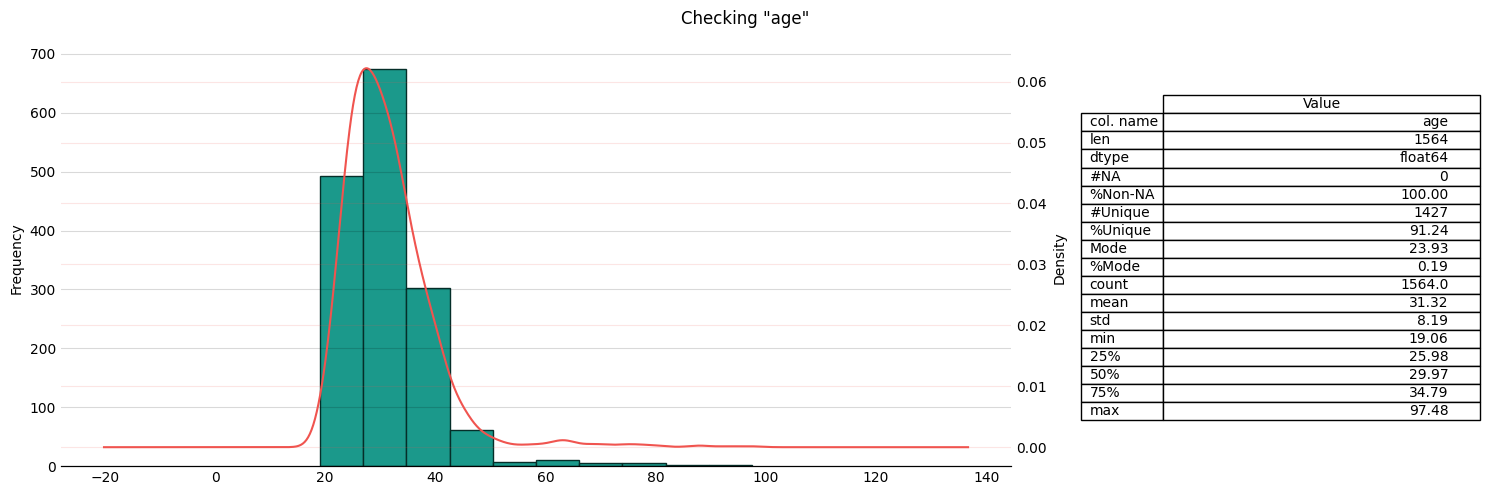

#### Checking is_alive

name | is_alive
-|-
len | 1564 
dtype | bool 
#NA | 0 
%Non-NA | 100.00 
#Unique | 2 
%Unique | 0.13 
Mode | True 
%Mode | 99.17 
count | 1564 
unique | 2 
top | True 
freq | 1551 


#### Checking height

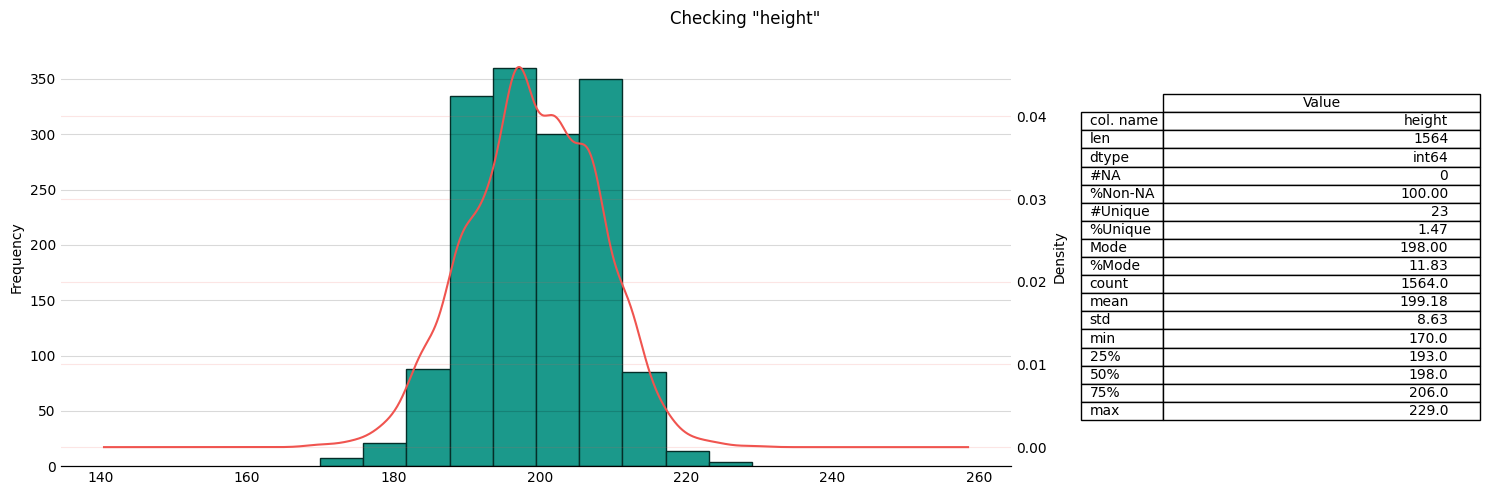

#### Checking weight

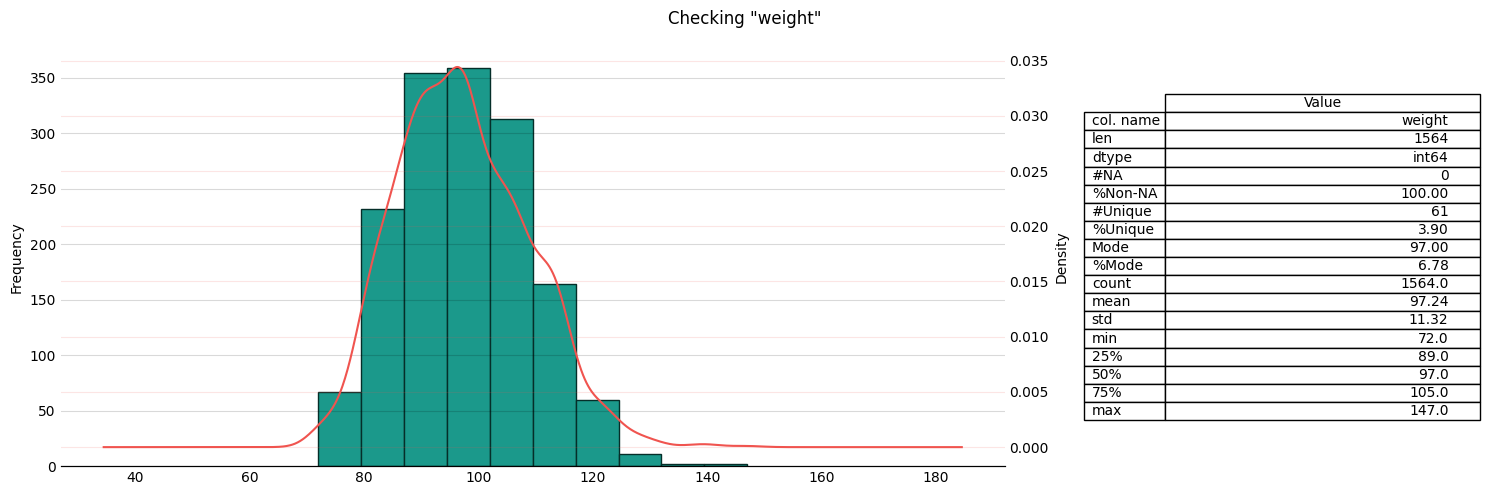

#### Checking career_length

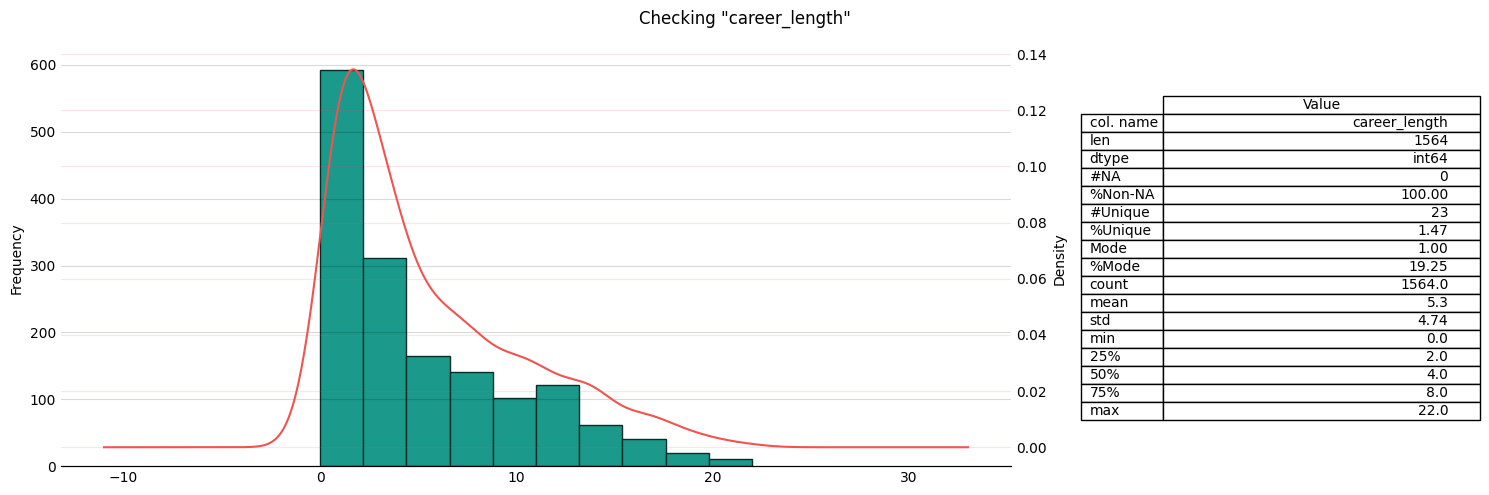

#### Checking is_active

name | is_active
-|-
len | 1564 
dtype | bool 
#NA | 0 
%Non-NA | 100.00 
#Unique | 2 
%Unique | 0.13 
Mode | True 
%Mode | 61.45 
count | 1564 
unique | 2 
top | True 
freq | 961 


#### Checking has_hall_of_fame

name | has_hall_of_fame
-|-
len | 1564 
dtype | bool 
#NA | 0 
%Non-NA | 100.00 
#Unique | 2 
%Unique | 0.13 
Mode | False 
%Mode | 97.25 
count | 1564 
unique | 2 
top | False 
freq | 1521 


#### Checking count_allstar

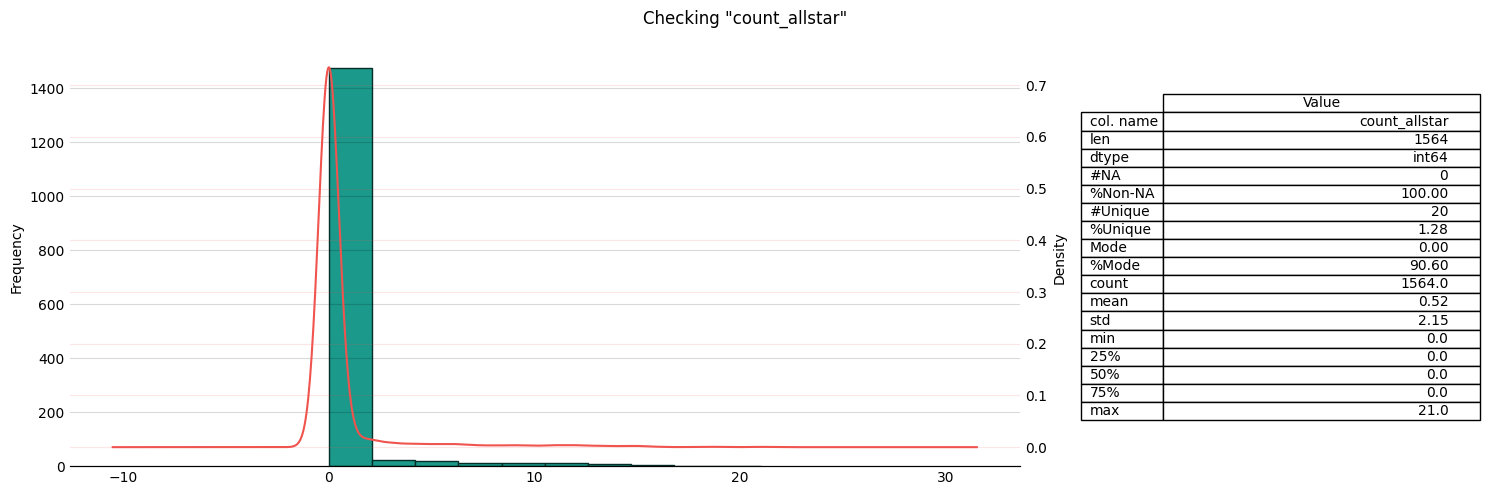

#### Checking stat_games

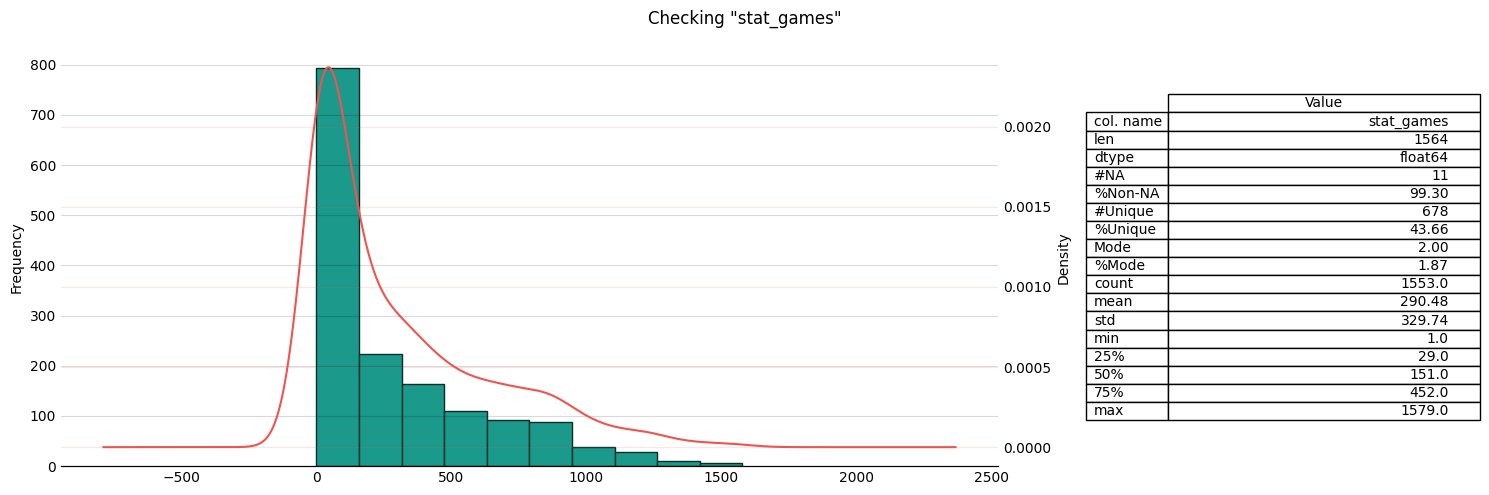

#### Checking stat_points

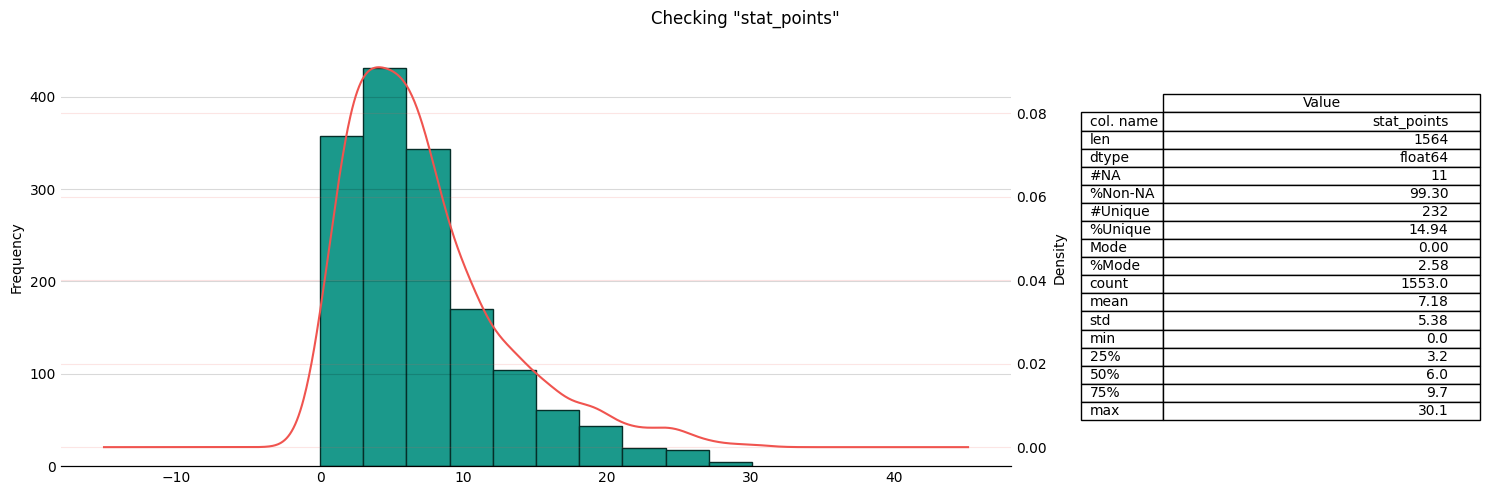

#### Checking stat_total_rebounds

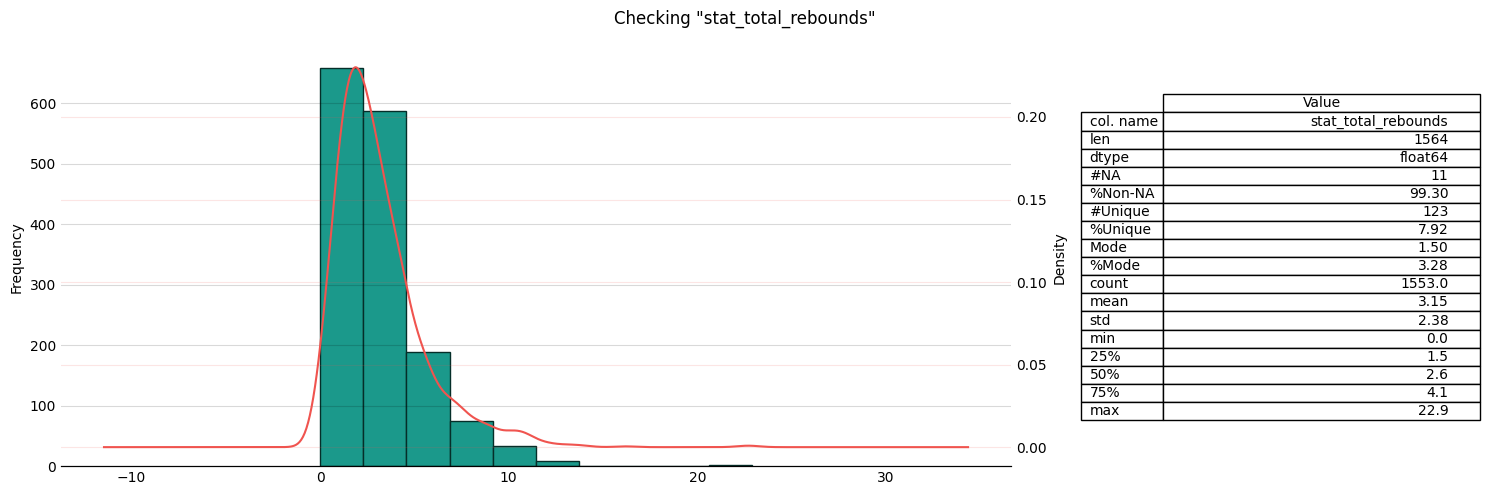

#### Checking stat_assists

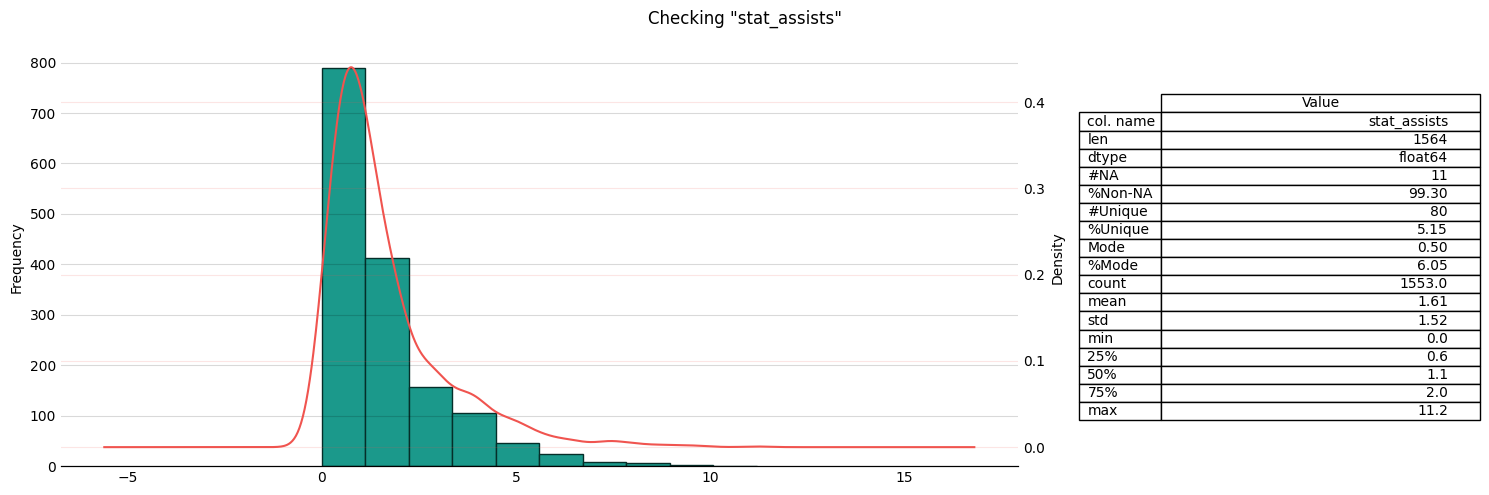

#### Checking stat_field_goal_pct

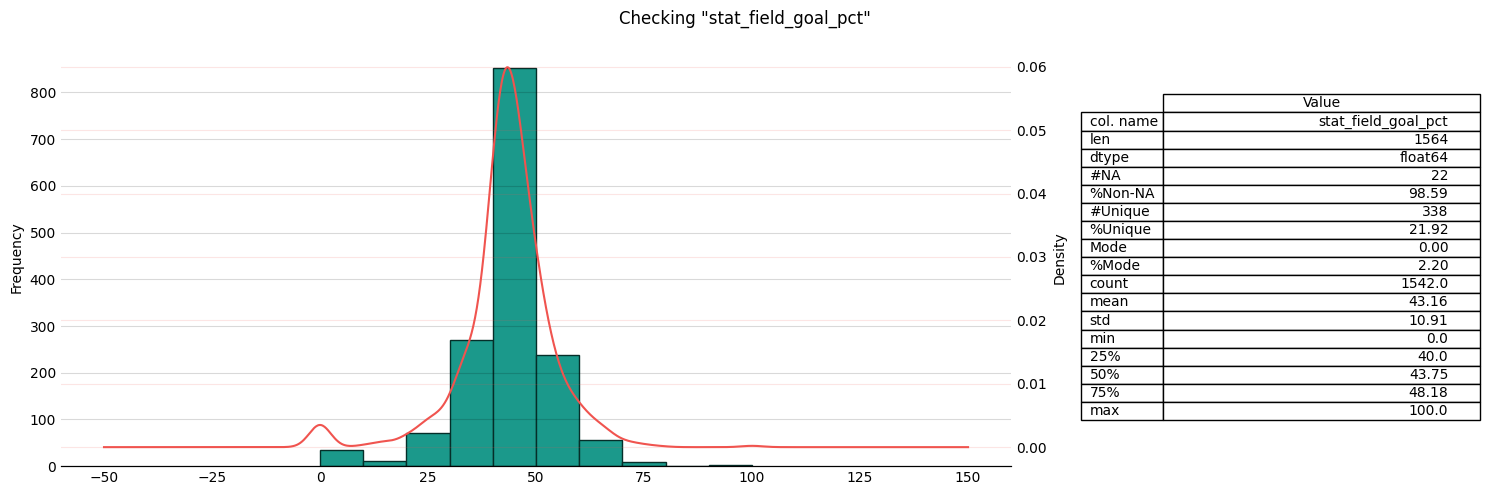

#### Checking stat_three_point_field_goal_pct

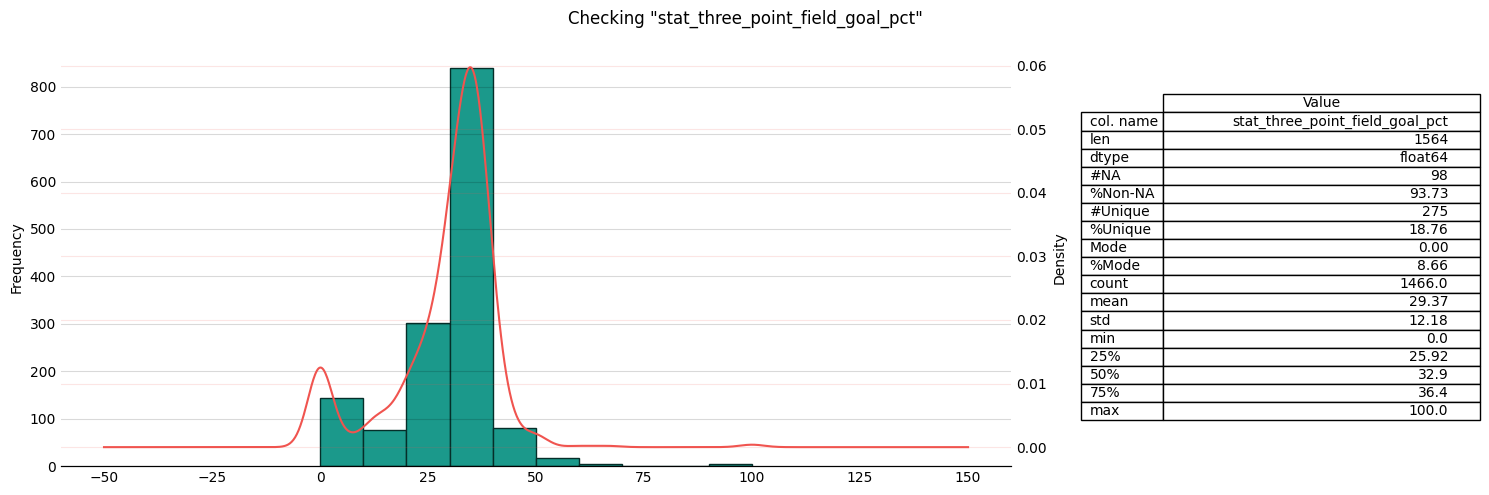

#### Checking stat_effective_field_goal_pct

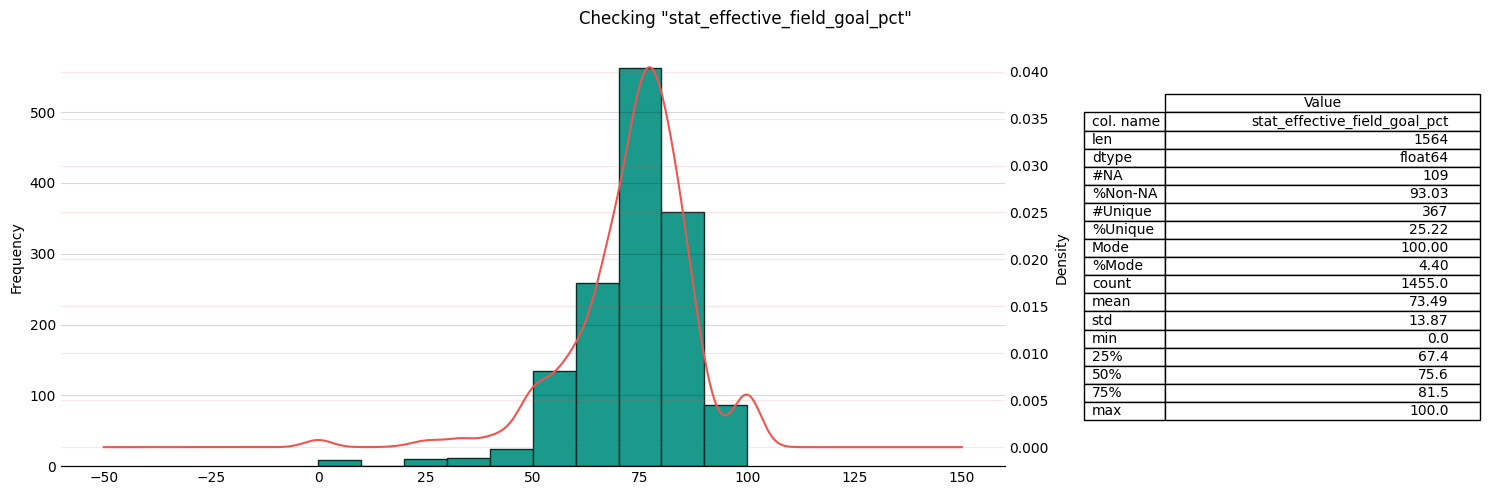

#### Checking stat_free_throw_pct

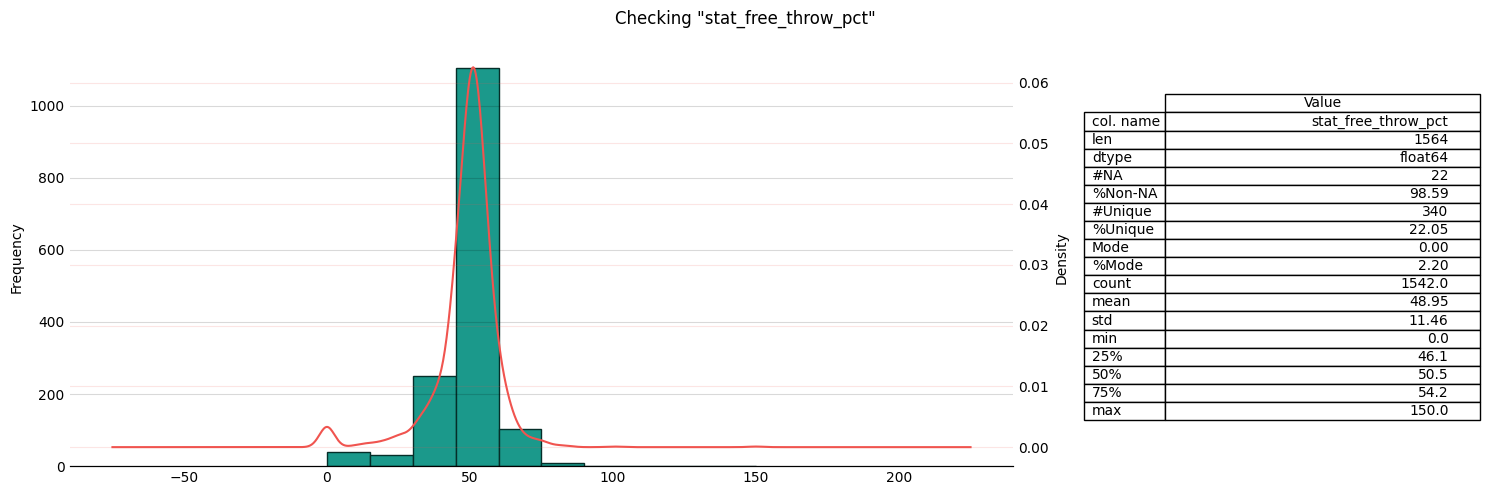

#### Checking stat_efficiency_rating

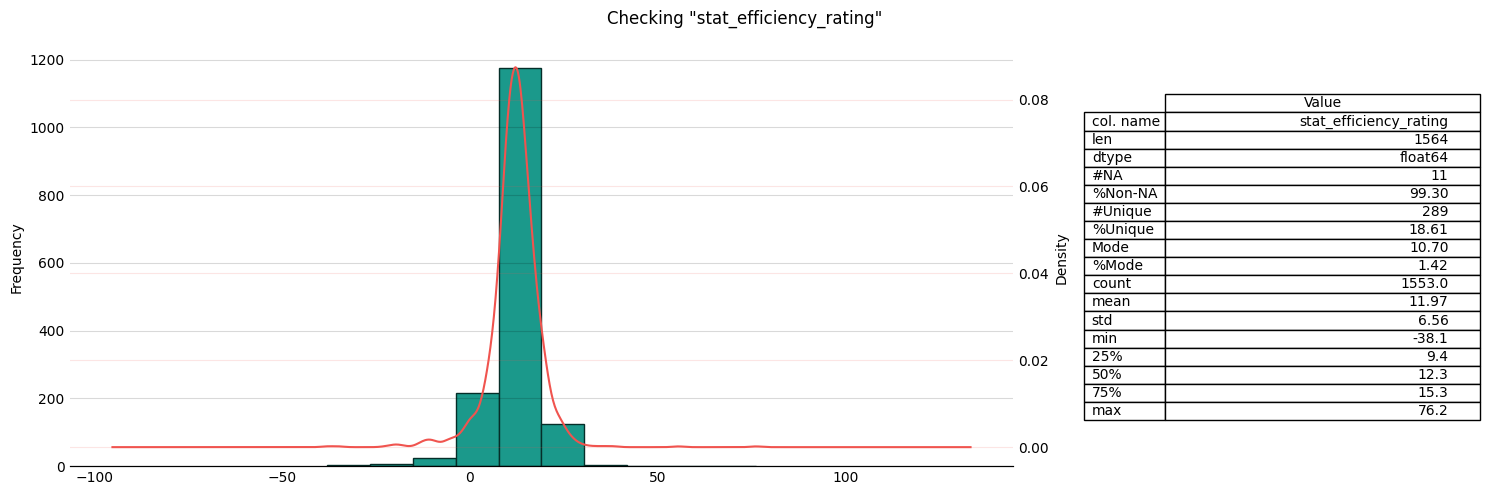

#### Checking stat_win_shares

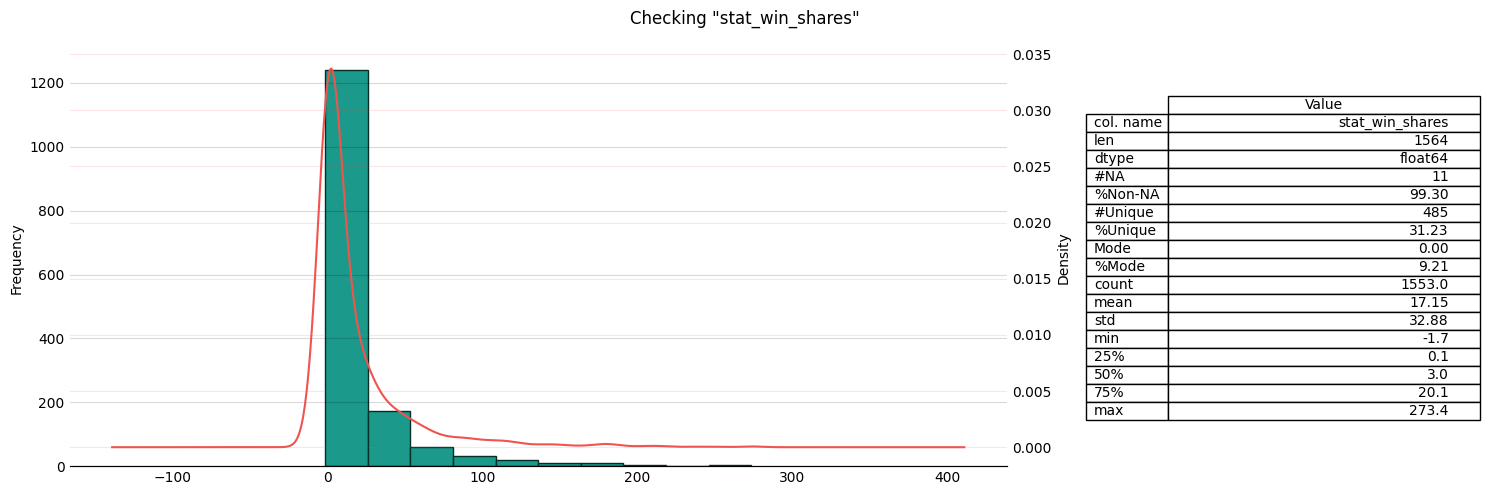

In [326]:
for column in df_players.columns:
    # print(f"checking {column}")
    check(df_players[column])

<div dir=rtl>

## آزمون فرض

</div>